In [3]:
import pandas as pd

df = pd.read_csv("kddcup.data_10_percent", header=None, low_memory=False)
df.shape


(494021, 42)

In [5]:
y_raw = df[41]
X_raw = df.drop(columns=[41])

In [12]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# detect column types
cat_cols = X_raw.select_dtypes(include=['object']).columns
num_cols = X_raw.columns.difference(cat_cols)

# encode categoricals
X_cat = pd.get_dummies(X_raw[cat_cols], drop_first=False)

# numeric → float + scale 0..1
X_num = X_raw[num_cols].astype(float)
scaler = MinMaxScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=X_num.columns,
    index=X_num.index
)

# final matrix & binary labels (1=attack, 0=normal)
X = pd.concat([X_num_scaled, X_cat], axis=1)
y = (y_raw != 'normal.').astype(int)
X.columns = X.columns.astype(str)
X.shape, y.value_counts()

((494021, 118),
 41
 1    396743
 0     97278
 Name: count, dtype: int64)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((345814, 118), (148207, 118))

In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=30,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42
)
mlp.fit(X_train, y_train)


,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,30
,shuffle,True
,random_state,42


Matplotlib is building the font cache; this may take a moment.


✅ Test Accuracy: 0.9995

📊 Classification Report:
               precision    recall  f1-score   support

           0     0.9988    0.9988    0.9988     29184
           1     0.9997    0.9997    0.9997    119023

    accuracy                         0.9995    148207
   macro avg     0.9992    0.9992    0.9992    148207
weighted avg     0.9995    0.9995    0.9995    148207


🧾 Confusion Matrix:
 [[ 29149     35]
 [    36 118987]]


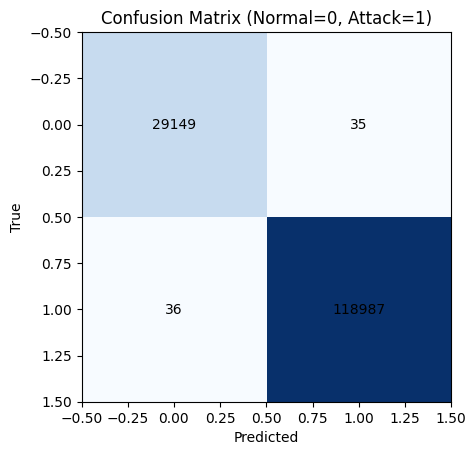

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = mlp.predict(X_test)

# Metrics
print("✅ Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("\n🧾 Confusion Matrix:\n", cm)

# Draw confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.set_title("Confusion Matrix (Normal=0, Attack=1)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()


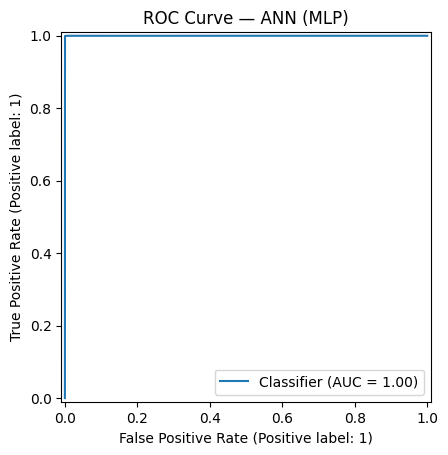

ROC-AUC Score: 1.0


In [16]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

y_prob = mlp.predict_proba(X_test)[:,1]
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — ANN (MLP)")
plt.show()

print("ROC-AUC Score:", round(roc_auc_score(y_test, y_prob), 4))

In [19]:
# DEMO
import pandas as pd

# Pick a random sample from test set
random_sample = X_test.sample(1, random_state=42)
actual_label = y_test.loc[random_sample.index].values[0]

prediction = mlp.predict(random_sample)[0]
prob = mlp.predict_proba(random_sample)[0][1]

print("✅ Random Connection Test")
print("Features (first 10 columns):")
print(random_sample.iloc[0,:10])

print("\nActual Label:", "Attack" if actual_label == 1 else "Normal")
print("Predicted Label:", "Attack" if prediction == 1 else "Normal")
print(f"Attack Probability: {prob:.4f}")


✅ Random Connection Test
Features (first 10 columns):
0     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
Name: 52317, dtype: object

Actual Label: Attack
Predicted Label: Attack
Attack Probability: 1.0000
